# BAN6800-Module-5-Business Analytics Model Results Communication
# ---- REPORTS & DASHBOARD ----
## Shield360 Project - Subscriber Churn Prediction Model
## Voke H Edafejimue

### IMPORT LIBRARIES

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle
import plotly.express as px
import plotly.graph_objs as go
from dash.dependencies import Input, Output
import numpy as np
import dash
from dash import Dash, dcc, html
import dash_bootstrap_components as dbc
import plotly.graph_objs as go

###  Load Dataset

In [53]:
#Load the dataset
df = pd.read_csv("telco_churn_cleaned.csv")
df.shape

(7043, 76)

### Load the Saved Model and its features

In [61]:
# Load the feature list used during training
import pickle
with open('gbdt_features.pkl', 'rb') as f:
    feature_names = pickle.load(f)

# One-hot encode or preprocess the same way as training
df_encoded = pd.get_dummies(df)

# Align columns to match the training features (fill missing ones with 0)
for col in feature_names:
    if col not in df_encoded.columns:
        df_encoded[col] = 0

df_encoded = df_encoded[feature_names]

# Load model
with open('gbdt_model.pkl', 'rb') as f:
    gbdt_model = pickle.load(f)

# Check if the model is loaded correctly by printing its type
print(type(gbdt_model))


# Predict
y_pred = gbdt_model.predict(df_encoded)


# Filter your new data to match the trained feature set
X_pred = df[feature_names]


# Print the predictions
print(y_pred)

<class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
[1 1 1 ... 0 0 0]


## Business Analytics Model Results Communication

### Report 1

In [63]:
# Cost of Subscriber Acquisition vs Subscriber Retention Analysis
# App initialization
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])
server = app.server

# Infographic layout
app.layout = dbc.Container([
    html.H1("📊 Cost of Subscriber Acquisition vs Subscriber Retention", className='text-center text-primary mb-4'),

    dbc.Row([
        # Retention Block
        dbc.Col([
            dbc.Card([
                dbc.CardHeader("✅ Subscriber Retention", className="bg-success text-white"),
                dbc.CardBody([
                    html.H3("$50 – $100", className="text-success"),
                    html.P("Cost to retain an existing subscriber"),
                    html.P("5% increase in retention = up to 95% profit increase", className="text-muted small"),
                    html.Img(src="https://img.icons8.com/fluency/96/handshake.png", height="60px")
                ])
            ])
        ], width=6),

        # Acquisition Block
        dbc.Col([
            dbc.Card([
                dbc.CardHeader("❌ Subscriber Acquisition", className="bg-danger text-white"),
                dbc.CardBody([
                    html.H3("$400 – $700", className="text-danger"),
                    html.P("Cost to acquire a new subscriber"),
                    html.P("Ads, sales, onboarding & incentives needed", className="text-muted small"),
                    html.Img(src="https://img.icons8.com/fluency/96/customer-insight.png", height="60px")
                ])
            ])
        ], width=6),
    ], className="mb-4"),

    # Bar Comparison Chart
    dbc.Row([
        dbc.Col([
            dcc.Graph(
                figure=go.Figure(data=[
                    go.Bar(name='Retention', x=['Retention'], y=[100], marker_color='green'),
                    go.Bar(name='Acquisition', x=['Acquisition'], y=[500], marker_color='red')
                ]).update_layout(
                    title='Cost Comparison (USD)',
                    yaxis_title='Average Cost per Subscriber ($)',
                    barmode='group'
                )
            )
        ])
    ]),

    html.Div([
        html.P("📌 Source: Bain & Company, Forbes, HubSpot", className="text-muted text-center")
    ])
], fluid=True)

# Run
if __name__ == '__main__':
    app.run(debug=True, port=8055)

### Report 2

In [93]:
# Scenario 1: Churn Overview & Current Situation
# Calculate churn rates by gender
churn_rate = df.groupby('Gender')['Churn Value'].value_counts(normalize=True).unstack().fillna(0).reset_index()
df['Gender'] = df['Gender'].replace({0: 'Male', 1: 'Female'})

# Rename columns for clarity
churn_rate.columns = ['Gender', 'Not Churned', 'Churned']

# Reshape the DataFrame for Plotly
churn_rate_melted = churn_rate.melt(id_vars='Gender', 
                                     value_vars=['Churned', 'Not Churned'], 
                                     var_name='Churn Status', 
                                     value_name='Rate')

# Create the bar chart
fig1 = px.bar(churn_rate_melted, 
              x='Gender', 
              y='Rate', 
              color='Churn Status', 
              barmode='stack',
              title="Churn Rate by Gender")


# Scenario 2: Model's Prediction of Churn and Impact on Revenue
# Predict churn using the GBDT model
X = df.drop(columns=['Churn Value', 'Customer ID'])
y_pred = gbdt_model.predict(df_encoded)
df['Predicted Churn'] = y_pred

# Calculate churn impact (revenue loss due to churned subscribers)
churned_customers = df[df['Predicted Churn'] == 1]
revenue_loss = churned_customers['Monthly Charges'].sum()

# Create a pie chart of predicted churn vs non-churn
churn_dist = df['Predicted Churn'].value_counts(normalize=True)
fig2 = go.Figure(data=[go.Pie(labels=['Churned', 'Non-Churned'], values=churn_dist)])

# Scenario 3: Predicting Churn Based on Features (e.g., Tenure)
# Group churn by tenure and plot churn prediction
churn_by_tenure = df.groupby('Tenure Months')['Predicted Churn'].mean().reset_index()
fig3 = px.line(churn_by_tenure, x='Tenure Months', y='Predicted Churn', title='Predicted Churn by Tenure Months')

# Scenario 4: Subscriber Segmentation for Targeted Retention Campaigns
# Segment subscribers based on churn risk (high vs low risk)
df['Churn Risk'] = df['Predicted Churn'].apply(lambda x: 'High Risk' if x == 1 else 'Low Risk')

# Create bar plot of subscriber segmentation
fig4 = px.bar(df, x='Churn Risk', title="Subscriber Segmentation Based on Churn Risk")

# Scenario 5: Churn Reduction Simulation - Impact of Interventions
# --------------------------------------------------------------
# This section simulates the effect of churn reduction (e.g., reducing churn by 10%) on the company’s revenue.
# Stakeholders can visualize how much revenue can be recovered with churn reduction strategies.

# Simulate 10% reduction in churn
reduced_churn_revenue_loss = revenue_loss * 0.9

# Create a bar plot comparing current revenue loss vs projected loss after churn reduction
fig5 = go.Figure([
    go.Bar(x=['Current', 'With Churn Reduction'], y=[revenue_loss, reduced_churn_revenue_loss], name='Revenue Loss')
])

# Initialize Dash app
app = dash.Dash(__name__)

# Define the layout of the app
app.layout = html.Div(children=[
    html.H1("Subscriber Churn Insights & Impact Analysis"),
    
    # Churn Overview & Current Situation
    html.H2("Churn Overview by Gender"),
    html.P("This section shows the current churn distribution by gender."),
    dcc.Graph(id='churn_rate_gender', figure=fig1),
    
    # Model's Prediction of Churn and Revenue Impact
    html.H2("Churn Prediction and Revenue Impact"),
    html.P(f"Estimated revenue loss from churned customers: ${revenue_loss:,.2f}"),
    dcc.Graph(id='churn_prediction', figure=fig2),
    
    # Predicting Churn Based on Tenure
    html.H2("Predicted Churn by Tenure Months"),
    html.P("This chart shows how churn predictions change with customer tenure."),
    dcc.Graph(id='churn_by_tenure', figure=fig3),
    
    # Subscriber Segmentation Based on Churn Risk
    html.H2("Customer Segmentation Based on Churn Risk"),
    html.P("This segmentation helps target high-risk customers for retention efforts."),
    dcc.Graph(id='customer_segmentation', figure=fig4),
    
    # Churn Reduction Impact on Revenue
    html.H2("Impact of Churn Reduction on Revenue"),
    html.P(f"Projected revenue loss with a 10% churn reduction: ${reduced_churn_revenue_loss:,.2f}"),
    dcc.Graph(id='churn_reduction_impact', figure=fig5),
])

if __name__ == '__main__':
    app.run(mode='inline', port=8058, debug=True)

### Report 3

In [73]:
#Revenue Loss from Churn (Bar Chart)
# Predicted churn column from your GBDT model
df['Predicted Churn'] = df['Predicted Churn'].astype(int)

# Aggregate revenue by churn status
revenue_df = df.groupby("Predicted Churn")["Total Revenue"].sum().reset_index()
revenue_df["Churn Status"] = revenue_df["Predicted Churn"].map({0: "Retained", 1: "Churned"})

# Create figure
fig = px.bar(revenue_df,
             x="Churn Status",
             y="Total Revenue",
             title="💸 Revenue Distribution: Retained vs Churned Subscribers",
             text="Total Revenue",
             color="Churn Status",
             color_discrete_map={"Retained": "green", "Churned": "red"})

# Dash App
app = dash.Dash(__name__)
app.layout = html.Div([
    html.H2("Impact of Churn on Revenue", style={"textAlign": "center"}),
    dcc.Graph(figure=fig)
])

if __name__ == "__main__":
    app.run(debug=True, port=8059)


### Report 4

In [42]:
# Model Performances
# Create a simple DataFrame of model results
data = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'GBDT', 'Neural Network'],
    'F1 Score (Train)': [0.9086, 0.9361, 0.9300, 0.9865, 0.9758],
    'F1 Score (Test)': [0.9092, 0.9328, 0.9291, 0.9355, 0.9331],
    'Recall (Test)': [0.9023, 0.9170, 0.9088, 0.9240, 0.9242]
}

df = pd.DataFrame(data)
df_long = df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# DASH APP
app = dash.Dash(__name__)
app.title = "Model Comparison Dashboard"

app.layout = html.Div([
    html.H2("📈 Model Performance Comparison", style={'textAlign': 'center'}),

    dcc.Graph(
        id='model-comparison-graph',
        figure=px.bar(
            df_long,
            x='Model',
            y='Score',
            color='Metric',
            barmode='group',
            text='Score',
            title='Comparison of Machine Learning Models on Churn Prediction',
            color_discrete_map={
                'F1 Score (Train)': '#1f77b4',
                'F1 Score (Test)': '#ff7f0e',
                'Recall (Test)': '#2ca02c'
            }
        ).update_layout(yaxis=dict(title='Score'), xaxis=dict(title='Model'))
    )
])

# RUN APP
if __name__ == '__main__':
    app.run(debug=True, port=8056)


### Report 5

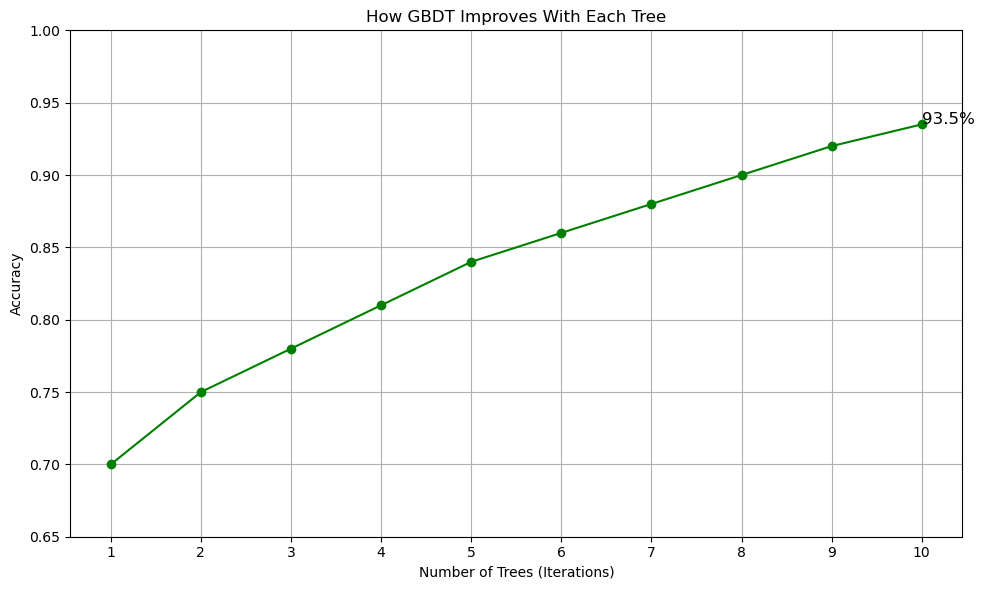

In [46]:
# How GBDT Improves With Each Tree
# Simulated model improvement over 10 trees
trees = np.arange(1, 11)
accuracy = [0.70, 0.75, 0.78, 0.81, 0.84, 0.86, 0.88, 0.90, 0.92, 0.935]  # Simulated accuracy values

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(trees, accuracy, marker='o', linestyle='-', color='green')
plt.title("How GBDT Improves With Each Tree")
plt.xlabel("Number of Trees (Iterations)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xticks(trees)
plt.ylim(0.65, 1.0)

# Annotate the final point
plt.text(trees[-1], accuracy[-1], f"{accuracy[-1]*100:.1f}%", fontsize=12, ha='left')

plt.tight_layout()
plt.show()

### Report 6

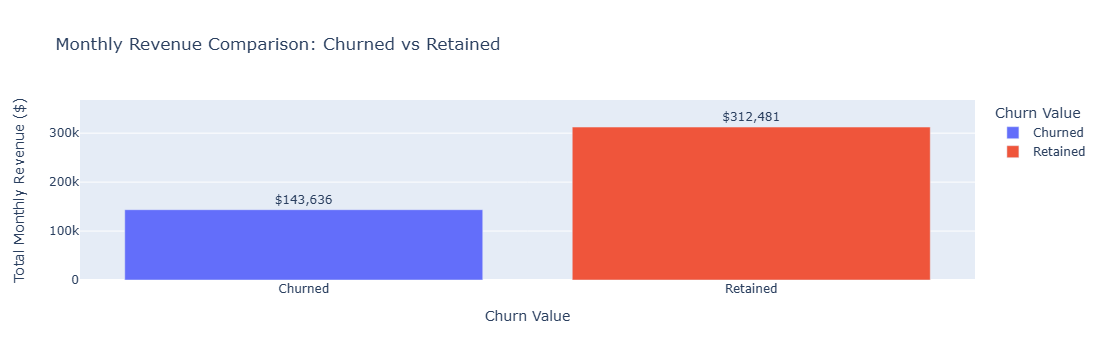

In [91]:

df['Churn Value'] = df['Predicted Churn'].replace({0: 'Retained', 1: 'Churned'})
revenue_by_churn = df.groupby('Churn Value')['Monthly Charges'].sum().reset_index()

fig = px.bar(revenue_by_churn, x='Churn Value', y='Monthly Charges',
             color='Churn Value', text='Monthly Charges',
             title='Monthly Revenue Comparison: Churned vs Retained',
             labels={'Monthly Charges': 'Total Monthly Revenue ($)'})
fig.update_traces(texttemplate='$%{text:,.0f}', textposition='outside')
fig.update_layout(uniformtext_minsize=6, uniformtext_mode='hide')
fig.show()

### Interactive Dashboard

In [95]:
# DATA PREPROCESSING

# Gender mapping
df["Gender"] = df["Gender"].replace({1: "Male", 0: "Female"}).fillna(df["Gender"])

# Create a Contract Status column
def map_contract(row):
    if row['Contract_One year'] == 1:
        return 'One Year'
    elif row['Contract_Two year'] == 1:
        return 'Two Year'
    else:
        return 'Month-to-Month'

df['Contract_Status'] = df.apply(map_contract, axis=1)

# Prepare data for model input
df_encoded = pd.get_dummies(df)
for col in feature_names:
    if col not in df_encoded.columns:
        df_encoded[col] = 0
X = df_encoded[feature_names]

# Predict churn
df["Predicted Churn"] = gbdt_model.predict(X)
df["Churn Risk"] = df["Predicted Churn"].apply(lambda x: "High" if x == 1 else "Low")


# DASH APP LAYOUT
app = dash.Dash(__name__, title="Taco-Tel's Churn Dashboard")

app.layout = html.Div([
    html.H1("📊 Taco-Tel's Churn Analysis Dashboard", style={'textAlign': 'center'}),

    html.Div([
        html.Div([
            html.Label("Filter by Gender:"),
            dcc.Dropdown(
                options=[{"label": gender, "value": gender} for gender in df["Gender"].unique()],
                id="gender-filter",
                placeholder="Select Gender",
                multi=True
            ),
        ], style={'width': '30%', 'display': 'inline-block'}),

        html.Div([
            html.Label("Filter by Contract Type:"),
            dcc.Dropdown(
                options=[{"label": status, "value": status} for status in df["Contract_Status"].unique()],
                id="contract-filter",
                placeholder="Select Contract Type",
                multi=True
            ),
        ], style={'width': '30%', 'display': 'inline-block', 'marginLeft': '2%'}),

        html.Div([
            html.Label("Simulate Churn Reduction (%):"),
            dcc.Slider(id='churn-slider', min=0, max=100, step=5, value=0,
                       marks={i: f"{i}%" for i in range(0, 101, 20)})
        ], style={'width': '35%', 'float': 'right'}),
    ], style={'marginBottom': '30px'}),

    dcc.Tabs([
        dcc.Tab(label="📉 Churn Overview", children=[
            dcc.Graph(id='churn-overview'),
            dcc.Graph(id='revenue-impact'),
        ]),
        dcc.Tab(label="📈 Tenure vs Churn", children=[
            dcc.Graph(id='tenure-vs-churn')
        ]),
        dcc.Tab(label="🌍 Churn by City", children=[
            dcc.Graph(id='churn-map')
        ]),
        dcc.Tab(label="🎯 Subscriber Segmentation", children=[
            dcc.Graph(id='segmentation-view')
        ]),
        dcc.Tab(label="📦 Charges vs Tenure", children=[
            dcc.Graph(id='charges-tenure')
        ]),
        dcc.Tab(label="💸 CLTV Distribution", children=[
            dcc.Graph(id='cltv-distribution')
        ]),
        dcc.Tab(label="🏙️ Top 10 Churning Cities", children=[
            dcc.Graph(id='top-churn-cities')
        ]),
        dcc.Tab(label="📤 Export Data", children=[
            html.Button("Download CSV", id="download-btn"),
            dcc.Download(id="download-dataframe-csv")
        ]),
    ])
])


# CALLBACKS
def filter_data(gender, contract):
    df_filtered = df.copy()
    if gender:
        df_filtered = df_filtered[df_filtered["Gender"].isin(gender)]
    if contract:
        df_filtered = df_filtered[df_filtered["Contract_Status"].isin(contract)]
    return df_filtered

@app.callback(
    Output("churn-overview", "figure"),
    Input("gender-filter", "value"),
    Input("contract-filter", "value")
)
def update_churn_chart(gender, contract):
    data = filter_data(gender, contract)
    churn = data["Predicted Churn"].value_counts(normalize=True)
    return px.pie(values=churn.values, names=["Not Churned", "Churned"],
                  title="Predicted Churn Distribution")

@app.callback(
    Output("revenue-impact", "figure"),
    Input("churn-slider", "value")
)
def simulate_revenue_loss(percent):
    loss_now = df[df["Predicted Churn"] == 1]["Monthly Charges"].sum()
    loss_reduced = loss_now * (1 - percent / 100)
    return px.bar(x=["Current Loss", f"Reduced Loss ({percent}%)"], y=[loss_now, loss_reduced],
                  labels={"x": "Scenario", "y": "Revenue Loss ($)"},
                  title="Revenue Loss Simulation")

@app.callback(
    Output("tenure-vs-churn", "figure"),
    Input("gender-filter", "value"),
    Input("contract-filter", "value")
)
def churn_by_tenure(gender, contract):
    data = filter_data(gender, contract)
    grouped = data.groupby("Tenure Months")["Predicted Churn"].mean().reset_index()
    return px.line(grouped, x="Tenure Months", y="Predicted Churn", title="Churn vs Tenure")

@app.callback(
    Output('churn-map', 'figure'),
    Input('gender-filter', 'value'),
    Input('contract-filter', 'value')
)
def update_churn_by_city(gender, contract):
    df_filtered = df.copy()

    # Apply filters
    if gender:
        df_filtered = df_filtered[df_filtered['Gender'].isin(gender)]
    if contract:
        df_filtered = df_filtered[df_filtered['Contract_One year'].isin(contract)]

    # Group by city and calculate average predicted churn
    city_churn = df_filtered.groupby('City', as_index=False)['Predicted Churn'].mean()
    city_churn.columns = ['City', 'Churn Rate']
    city_churn = city_churn.sort_values(by='Churn Rate', ascending=False).head(30)

    # Plot
    fig = px.bar(
        city_churn,
        x='City',
        y='Churn Rate',
        color='Churn Rate',
        title='Top Cities by Churn Rate',
        color_continuous_scale='Reds'
    )

    fig.update_layout(xaxis_tickangle=45)
    return fig

@app.callback(
    Output("segmentation-view", "figure"),
    Input("gender-filter", "value"),
    Input("contract-filter", "value")
)
def segment_by_churn(gender, contract):
    data = filter_data(gender, contract)
    return px.histogram(data, x="Churn Risk", color="Gender", barmode="group",
                        title="Subscriber Segments by Churn Risk")

@app.callback(
    Output("charges-tenure", "figure"),
    Input("gender-filter", "value"),
    Input("contract-filter", "value")
)
def charges_vs_tenure(gender, contract):
    data = filter_data(gender, contract)
    return px.scatter(data, x="Tenure Months", y="Monthly Charges", size="CLTV",
                      color="Predicted Churn", title="Charges vs Tenure")

@app.callback(
    Output("cltv-distribution", "figure"),
    Input("gender-filter", "value"),
    Input("contract-filter", "value")
)
def cltv_hist(gender, contract):
    data = filter_data(gender, contract)
    return px.histogram(data, x="CLTV", color="Predicted Churn", nbins=40,
                        title="CLTV Distribution by Churn Risk")

@app.callback(
    Output("top-churn-cities", "figure"),
    Input("gender-filter", "value"),
    Input("contract-filter", "value")
)
def top_churn_cities(gender, contract):
    data = filter_data(gender, contract)
    churned = data[data["Predicted Churn"] == 1]
    top_cities = churned["City"].value_counts().nlargest(10).reset_index()
    top_cities.columns = ["City", "Churn Count"]
    return px.bar(top_cities, x="City", y="Churn Count", title="Top Churn Cities")

@app.callback(
    Output("download-dataframe-csv", "data"),
    Input("download-btn", "n_clicks"),
    prevent_initial_call=True,
)
def download_csv(n_clicks):
    return dcc.send_data_frame(df.to_csv, "Telco_Predictions.csv")


# RUN
if __name__ == "__main__":
    app.run(debug=True, port=8094)


### References

### Anmol Tomar. March 17, 2021. Dash for Beginners: Create Interactive Python Dashboards. Towards Data Science. https://towardsdatascience.com/dash-for-beginners-create-interactive-python-dashboards-338bfcb6ffa4/
### Python Geeks Team. N.d. Develop Data Visualization Interfaces in Python With Dash. https://pythongeeks.org/data-visualization-with-python-dash/